# Capstone Project - The Battle of Neighborhoods

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## I) Introduction <a name="introduction"></a>

<div style="text-align: justify">São Paulo is a city in the Southern Region of Brazil. The city is the capital of the state (São Paulo analogue with the city), the wealthiest city in the country and of South Hemisphere, one of the 20th wealthiest cities in the world, representing alone 10.7% of all Brazil GDP and the 13th most populous. Home of the São Paulo Stock Exchange. It exerts strong influence in commerce, finance, arts and entertainment in the country.<br>
Brazil is a country of many contrasts and São Paulo is not different. With a Human Development Index like a European country in some regions and low as a score of 0.700 in others regions.</div>
<div style="text-align: justify">Problems with high demographical density and with High Crime Rates. Given its diversity, the analysis will give good insight to cluster city´s districts with the same pattern and, in some level, help to understand where a new business should be placed.</div>
<div style="text-align: justify">The analysis will help to find the correct location for a business in the city, decreasing potential risks. Showing the profile of each cluster to open branches in districts with the same behaviour.<br></div>

## II) Data<a name="data"></a>

<div style="text-align: justify">The necessary information needed in the analysis will come from different sources like wikipedia, city hall homepage, foursquare and secretary of public security of the state of São Paulo. The description of each data and the cleansing needed for it will be explained bellow. And all the granularity of the information is by City´s Districts. The District is an administrative division that aggregates neighborhoods. The aggragation of Districts becomes a sub-prefecture. And finally the sub-prefecture becomes a city.<BR>
<ul>
<li><b>Geographic Boundaries:</b> Come from the City Hall Homepage, with each district in the city and each respective geographic boundaries. Using the coordinates, I calculated the mean to discover the center. And the file is in a shape format and it will be converted a json format.</li><BR>
</ul></div>

In [2]:
#loading the libraries
import shapefile #translate shp files to a json file
import json
from json import dumps
import folium
import pandas as pd
import requests
import numpy as np
from geopy.geocoders import Nominatim
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
print("load ready")

load ready


In [3]:
#read the file shp and read the geographical coordinates
reader = shapefile.Reader("C:/Estudo/IBM/Capstone/DISTRITO_MUNICIPAL_SP_SMDU/DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(geometry=geom, properties=atr))
print("load ready")

load ready


In [4]:
#write in a json file the coordinates given by the shp file.
geojson = open("C:/Estudo/IBM/Capstone/DISTRITO_MUNICIPAL_SP_SMDU/pyshp-demo_v2.json", "w")
geojson.write(dumps({"features": buffer}, indent=2) + "\n")
geojson.close()
print("file closed")

file closed


With the convertion from shp to json done, the next step is to view the map with the coordinates read from the json file.

In [47]:
#open the json file and generate a folium map.
sp_geo = r'C:/Estudo/IBM/Capstone/DISTRITO_MUNICIPAL_SP_SMDU/pyshp-demo.json'
sp = folium.map.FeatureGroup()
sp = folium.Map(location=[-23.5475, -46.63611], zoom_start=11)

#choropleth to draw the districts of São Paulo
sp.choropleth(
    geo_data=sp_geo,
    columns=['Country', 'Total'],
    key_on='feature.properties.name',
#    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='São Paulo City and its districts'
)

#sp

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<img src="sp_map.png" alt="sp map">

Create the lists with the coordinates of the boundaries of each district and calculates the mean to get the centroids.

In [6]:
#create empty lists
list = []
nome = []

#open the json file and load the coordinates to a list
with open(sp_geo) as json_file:
    data = json.load(json_file)
    for p in data['features']:
        for y in p['geometry']['coordinates']:
            list.append(y)
            nome.append(p["properties"]['Nome'])

#calculate the mean for each district
sp_districts = pd.DataFrame(columns=['Borough', 'Latitude', 'Longitude'])
lat = 0
log = 0
for i in range(len(list)):
    for j in range(len(list[i])):
        lat = lat + list[i][j][1]
        log = log + list[i][j][0]
    sp_districts = sp_districts.append({'Borough': nome[i], 'Latitude': lat / len(list[i]), 'Longitude': log / len(list[i])}, ignore_index=True)
    lat = 0
    log = 0


sp_districts.head()

,Borough,Latitude,Longitude
0,MANDAQUI,-23.462176,-46.640467
1,MARSILAC,-23.949529,-46.724111
2,MOEMA,-23.594287,-46.659987
3,PARQUE DO CARMO,-23.576289,-46.462777
4,PERDIZES,-23.540115,-46.680767


The centroids can be seen in the map below.

In [45]:

address = 'São Paulo, São Paulo'

geolocator = Nominatim(user_agent="ny_explorer")
try:
    location = geolocator.geocode(address, timeout=10)
    latitude = location.latitude
    longitude = location.longitude

except:
    print("Try again")
print('The geograpical coordinate of São Paulo are {}, {}.'.format(latitude, longitude))
# create map of São Paulo using latitude and longitude values
map_saopaulo = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, borough in zip(sp_districts['Latitude'], sp_districts['Longitude'], sp_districts['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_saopaulo)
#load map
#map_saopaulo

The geograpical coordinate of São Paulo are -23.5506507, -46.6333824.


<img src="sp_districts.png" alt="sp districts">

<ul>
<li><b>Population and Area:</b> Come from the City Hall Homepage, with the population of each district as consolidated in the last demographic census of 2010. And devived from these two pieces of information, the demoghaphic density.</li><BR>
<li><b>Aging Index:</b> Come from the City Hall Homepage, with the aging index for each district. The aging index is the population equal or over 60 years old divided by the population under 14 years old multiplied by 100.</li><BR>
<li><b>HDI:</b> Come from the Wikipedia. The data is from 2000, but is the most recent and trustworthy data that can be found in the internet.</li><BR>
<li><b>Crime Rate:</b> Come from the secretary of public security of the state of São Paulo. The Rate is the aggregation of all types of crimes divided by the population and multiplied by 1000. The data is from 2019. Not all the districts have information about crimes and to complete the required information, i used the mean given by the districts that the missing line is inserted.</li><BR>
</ul>

The four bases above was collected manually from each respective site and merged in excel resulting in the file data.csv.

In [8]:
with open('Data.csv') as csv_file:
    df = pd.read_csv(csv_file, delimiter=';')
df.head()

,subprefecture,districts,area_km2,population_2010,demographical_density,aging_index,HDI,crimes,crimes_per_1000pop
0,Mooca,AGUA RASA,"6,9",84963,"12313,48","146,11","0,886",2883,"33,932"
1,Pinheiros,ALTO DE PINHEIROS,"7,7",43117,"5599,61","229,4","0,955",16118,"373,82"
2,Perus,ANHANGUERA,"33,3",65859,"1977,75","38,94","0,774",7077,"107,457"
3,Aricanduva,ARICANDUVA,"6,6",89622,"13579,09","108,6","0,83",4523,"50,468"
4,Penha,ARTUR ALVIM,"6,6",105269,"15949,85","100,11","0,833",8106,"77,003"


<ul>
<li><b>Foursquare API:</b> The API will be used to generate the most Commons venues of each district. Due to the great diversity of venues given by the API, it will be necessary to cluster types of business such as restaurants in a only one type.</li><BR>
As a initial setup, I need to set the Client_ID, Client_Secret and the Version to access the API.<BR></ul>

CLIENT_ID = 'XXXXXXXXXXX'<BR>
CLIENT_SECRET = 'XXXXXXXXXXXX'<BR>
VERSION = '20180605'<BR>
<!--
CLIENT_ID = 'LDRO1FGI3TJF2WQD5G1ZNZU3T10KCEW5VQNZY422MVUYBBWI' # your Foursquare ID
CLIENT_SECRET = 'D3GMSNWLCDUZDOLUEX0GOMCKTGKTAK5ODQNEZGFPORHE0R0T' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
-->

Next, creat a function to connect with the API and a function to read the json file.

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


def getNearbyVenues(names, latitudes, longitudes, radius=500 # define radius
                    , LIMIT=100): # limit of number of venues returned by Foursquare API
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']

    return (nearby_venues)
print("function created")

function created


Then I used the function with the required parameters.

In [11]:
saopaulo_venues = getNearbyVenues(names=sp_districts['Borough'],
                                   latitudes=sp_districts['Latitude'],
                                   longitudes=sp_districts['Longitude']
                                  )

saopaulo_venues.shape

(2333, 7)

As it can be seen above, the dataframe has 2332 rows and 7 columns.

## III) Methodology <a name="methodology"></a>

<div style="text-align: justify">In this analysis, the goal is to find the districts cluster that have similar parameters and could be potencial places to install a new business. To do the analysis I did the steps as follow:<BR>
<BR>
<ul>
<li>In the first step, I prepared a file to cluster the same kind of business in the Foursquare, but come with different names. Merged the file with the base of Foursquare venues and dropped the unnecessary columns. <BR>
<li>In the second step, transposed the base and agregated the values by districts.<BR>
<li>In the third step, due to the different ranges of each variable and this fact could influence the analysis to the variable with the largest range, i normalized of them. And replace any NAN value with a 0.<BR>
<li>In the fourth step, I explored the data, using the describe and correlation functions to identify possible relations between the variables.<BR>
<li>And in the final step, I used the unsupervised learning algorithm, K-Means, because, in this analysis, the base didn´t have a target variable (Y). And as a result, the algorithm generated the clusters with districts with similar pattern. To finaly understand and describe with one of them.<BR></ul></div>

## IV) Analysis <a name="analysis"></a>

First, open the csv file with the new names for the Venues Categories to aggregate then.

In [12]:
with open('De_Para.csv') as csv_file:
    oldnew_df = pd.read_csv(csv_file, delimiter=';')

df_left = pd.merge(saopaulo_venues, oldnew_df, how='left', left_on='Venue Category', right_on='Old')
df_left
try:
    df_left.dropna(subset=['New'], inplace=True)
    df_left.drop('Venue Category', axis=1, inplace=True)
    df_left.drop('Old', axis=1, inplace=True)
    df_left.rename(columns = {'New':'Venue Category'}, inplace = True) 
except:
    df_left.shape
saopaulo_venues = df_left
saopaulo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MANDAQUI,-23.462176,-46.640467,CUA Centro de União de Arqueiros,-23.462746,-46.641027,Gym
1,MANDAQUI,-23.462176,-46.640467,super mercado andorinha,-23.464275,-46.639359,Market
3,MANDAQUI,-23.462176,-46.640467,Refeitório - Instituto Florestal,-23.460563,-46.638384,Regional Restaurant
4,MANDAQUI,-23.462176,-46.640467,kaiomix,-23.463416,-46.643549,International Restaurant
5,MANDAQUI,-23.462176,-46.640467,Café 3 corações,-23.460087,-46.636918,Coffee Shop


And result in the "Venue Category" as shown below.

In [13]:
saopaulo_venues['Venue Category'].unique()

array(['Gym', 'Market', 'Regional Restaurant', 'International Restaurant',
       'Coffee Shop', 'Park', 'Plaza', 'Stadium', 'Store',
       'fast food restaurant', 'Pharmacy', 'Service', 'Hospital',
       'Food Shop', 'Bar', 'Sports Field', 'General Entertainment',
       'Bakery', 'Theater', 'Shopping Plaza', 'Museum', 'Cultural Center',
       'Bank', 'Bus Station', 'Hotel', 'Club', 'Event Space', 'School',
       'Movie Theater'], dtype=object)

As a next step, to transform and transpose the base.

In [14]:
saopaulo_data = sp_districts.reset_index(drop=True)

# one hot encoding
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
saopaulo_onehot['Neighborhood'] = saopaulo_venues['Neighborhood']
fixed_columns = [saopaulo_onehot.columns[-1]]

max = len(saopaulo_onehot.columns[:-1])
for i in range(max):
    fixed_columns.append(saopaulo_onehot.columns[i])
saopaulo_onehot = saopaulo_onehot[fixed_columns]
saopaulo_onehot = saopaulo_onehot.rename(columns={'Neighborhood': 'districts'})
saopaulo_onehot.head(10)

,districts,Bakery,Bank,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,...,Plaza,Regional Restaurant,School,Service,Shopping Plaza,Sports Field,Stadium,Store,Theater,fast food restaurant
0,MANDAQUI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MANDAQUI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MANDAQUI,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,MANDAQUI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,MANDAQUI,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,MOEMA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,MOEMA,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,MOEMA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,MOEMA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11,MOEMA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And to group by "districts".

In [15]:
#group by results by neighborhood and calculate the mean
saopaulo_grouped = saopaulo_onehot.groupby('districts').mean().reset_index()
saopaulo_grouped.head()

,districts,Bakery,Bank,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,...,Plaza,Regional Restaurant,School,Service,Shopping Plaza,Sports Field,Stadium,Store,Theater,fast food restaurant
0,AGUA RASA,0.137931,0.00,0.172414,0.000000,0.0,0.000000,0.0,0.034483,0.137931,...,0.103448,0.034483,0.0,0.000000,0.0,0.0,0.000000,0.068966,0.0,0.068966
1,ALTO DE PINHEIROS,0.071429,0.00,0.000000,0.035714,0.0,0.035714,0.0,0.000000,0.107143,...,0.285714,0.107143,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.107143
2,ANHANGUERA,0.090909,0.00,0.000000,0.090909,0.0,0.000000,0.0,0.000000,0.272727,...,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.000000,0.090909,0.0,0.000000
3,ARICANDUVA,0.153846,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.153846,...,0.000000,0.076923,0.0,0.000000,0.0,0.0,0.076923,0.307692,0.0,0.076923
4,ARTUR ALVIM,0.050000,0.05,0.050000,0.000000,0.0,0.000000,0.0,0.000000,0.050000,...,0.000000,0.150000,0.0,0.000000,0.0,0.0,0.000000,0.300000,0.0,0.100000


The next step is to merge the dataframes and cast the variables from string to float.

In [16]:
df2 = pd.merge(df, saopaulo_grouped, how='left', left_on='districts', right_on='districts')
df2[["demographical_density", "aging_index", "HDI", "crimes_per_1000pop"]] = df2[["demographical_density", "aging_index", "HDI", "crimes_per_1000pop"]].replace(',','.', regex=True).astype("float")

As the data have different ranges, it is necessary to normalize them so that the values with greater variation do not influence the result of the algorithm that will be applied.<BR>

In [17]:
df2["demographical_density"] = (df2["demographical_density"] - df2["demographical_density"].min())/(df2["demographical_density"].max() - df2["demographical_density"].min())
df2["aging_index"] = (df2["aging_index"] - df2["aging_index"].min())/(df2["aging_index"].max() - df2["aging_index"].min())
df2["crimes_per_1000pop"] = (df2["crimes_per_1000pop"] - df2["crimes_per_1000pop"].min())/(df2["crimes_per_1000pop"].max() - df2["crimes_per_1000pop"].min())
df2["HDI"] = (df2["HDI"] - df2["HDI"].min())/(df2["HDI"].max() - df2["HDI"].min())

And replace any "NAN" value with 0.

In [18]:
df2.replace(np.nan, 0, inplace=True)

Then drop any unnecessary column of the dataframe.

In [19]:
try:
    df2.drop('subprefecture', axis=1, inplace=True)
    df2.drop('area_km2', axis=1, inplace=True)
    df2.drop('population_2010', axis=1, inplace=True)
    df2.drop('crimes', axis=1, inplace=True)
    df2.drop('Neighborhood', axis=1, inplace=True)
except:
    df2
df2.head()

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Bakery,Bank,Bar,Bus Station,Club,...,Plaza,Regional Restaurant,School,Service,Shopping Plaza,Sports Field,Stadium,Store,Theater,fast food restaurant
0,AGUA RASA,0.460079,0.357660,0.711538,0.011751,0.137931,0.00,0.172414,0.000000,0.0,...,0.103448,0.034483,0.0,0.000000,0.0,0.0,0.000000,0.068966,0.0,0.068966
1,ALTO DE PINHEIROS,0.208379,0.589485,0.976923,0.405625,0.071429,0.00,0.000000,0.035714,0.0,...,0.285714,0.107143,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.107143
2,ANHANGUERA,0.072597,0.059369,0.280769,0.096954,0.090909,0.00,0.000000,0.090909,0.0,...,0.000000,0.000000,0.0,0.090909,0.0,0.0,0.000000,0.090909,0.0,0.000000
3,ARICANDUVA,0.507526,0.253257,0.496154,0.030913,0.153846,0.00,0.000000,0.000000,0.0,...,0.000000,0.076923,0.0,0.000000,0.0,0.0,0.076923,0.307692,0.0,0.076923
4,ARTUR ALVIM,0.596405,0.229626,0.507692,0.061663,0.050000,0.05,0.050000,0.000000,0.0,...,0.000000,0.150000,0.0,0.000000,0.0,0.0,0.000000,0.300000,0.0,0.100000


With the dataframe ready, the first analysis is to get the mean, standard deviation, min, max and the quartiles with the describe function.

In [20]:
df2.describe()

,demographical_density,aging_index,HDI,crimes_per_1000pop,Bakery,Bank,Bar,Bus Station,Club,Coffee Shop,...,Plaza,Regional Restaurant,School,Service,Shopping Plaza,Sports Field,Stadium,Store,Theater,fast food restaurant
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.412344,0.234549,0.580208,0.100229,0.074632,0.000795,0.054698,0.004804,0.005764,0.026679,...,0.041235,0.082299,0.000401,0.019875,0.001710,0.014324,0.007954,0.111456,0.003060,0.078209
std,0.196399,0.154391,0.249326,0.162388,0.088116,0.005415,0.124247,0.021470,0.023293,0.053824,...,0.101604,0.080654,0.003925,0.038367,0.008185,0.035623,0.039030,0.100075,0.010735,0.090964
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.287501,0.121013,0.383654,0.025750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.408798,0.205258,0.586538,0.047621,0.053713,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.074085,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.062561
75%,0.529667,0.322840,0.771154,0.085586,0.102778,0.000000,0.063322,0.000000,0.000000,0.036045,...,0.027492,0.125000,0.000000,0.025329,0.000000,0.000000,0.000000,0.166667,0.000000,0.116477
max,1.000000,1.000000,1.000000,1.000000,0.500000,0.050000,1.000000,0.142857,0.173913,0.333333,...,0.666667,0.357143,0.038462,0.250000,0.050000,0.200000,0.333333,0.333333,0.064516,0.500000


Nothing of note here, but it´s good to keep the result in mind for the comparative with the resulting clusters.<BR>
Next calculate the correlation matrix for the dataframe.<BR>

In [21]:
df2.corr()

,demographical_density,aging_index,HDI,crimes_per_1000pop,Bakery,Bank,Bar,Bus Station,Club,Coffee Shop,...,Plaza,Regional Restaurant,School,Service,Shopping Plaza,Sports Field,Stadium,Store,Theater,fast food restaurant
demographical_density,1.000000,0.061098,0.033454,-0.155616,0.051841,0.129444,-0.050027,-0.061759,0.002751,0.033506,...,-0.156354,0.121620,-0.010054,0.020727,0.117642,-0.106862,-0.037890,0.159663,0.412431,0.149796
aging_index,0.061098,1.000000,0.607240,0.053983,-0.128034,-0.010798,0.131386,-0.067683,0.028469,0.374106,...,0.226125,0.089147,0.047323,0.016849,-0.069514,0.036833,-0.066086,-0.099370,0.200991,-0.091455
HDI,0.033454,0.607240,1.000000,0.197694,-0.068316,0.007357,0.201226,-0.099096,0.131516,0.190212,...,-0.009628,0.266032,0.024097,0.145210,-0.014652,0.084575,-0.039874,0.072050,0.323890,-0.054220
crimes_per_1000pop,-0.155616,0.053983,0.197694,1.000000,-0.137934,0.116114,-0.005116,-0.029649,0.226024,0.097751,...,0.015623,0.212177,-0.045061,-0.029553,0.174275,-0.061747,-0.070430,0.136810,0.276984,-0.161867
Bakery,0.051841,-0.128034,-0.068316,-0.137934,1.000000,-0.043762,-0.194290,0.160922,-0.060415,-0.274682,...,-0.170338,0.054788,-0.042336,0.013956,-0.150182,-0.009455,-0.076045,0.031706,-0.083097,0.006976
Bank,0.129444,-0.010798,0.007357,0.116114,-0.043762,1.000000,-0.004526,-0.033192,-0.036713,-0.029765,...,-0.053583,0.091979,-0.015141,-0.032989,-0.030995,-0.059652,-0.021610,0.230399,0.020416,0.023700
Bar,-0.050027,0.131386,0.201226,-0.005116,-0.194290,-0.004526,1.000000,-0.048200,-0.012309,-0.041995,...,-0.083734,-0.060521,0.050376,-0.037159,-0.055877,0.021664,-0.059136,-0.128536,0.065554,0.102292
Bus Station,-0.061759,-0.067683,-0.099096,-0.029649,0.160922,-0.033192,-0.048200,1.000000,-0.055952,-0.100451,...,-0.042519,-0.117200,-0.023076,-0.003523,-0.047237,-0.014024,-0.046075,-0.029605,-0.035901,0.116063
Club,0.002751,0.028469,0.131516,0.226024,-0.060415,-0.036713,-0.012309,-0.055952,1.000000,0.027549,...,-0.027453,-0.012685,-0.025523,0.118872,-0.022763,0.169149,-0.005370,0.005299,0.058822,0.038690
Coffee Shop,0.033506,0.374106,0.190212,0.097751,-0.274682,-0.029765,-0.041995,-0.100451,0.027549,1.000000,...,0.125252,0.107792,0.022577,-0.112104,0.042420,-0.100693,0.044933,-0.115020,0.118552,-0.126369


<div style="text-align: justify">All the correlations are very week to average. For example, the "Theater" has a average correlation with the demographical density. That result is expected. Another expected result is the average correlation between "HDI" and "aging index", because in the calculation of HDI is used the life expectancy. Two interesting results is the correlation between HDI and Theater and HDI and International Restaurant. In other words, the higher the HDI, the higher the quantity of the Theater and International Restaurants.<BR>
The next step of the analysis is to verify the boxplot of the variables.</div>

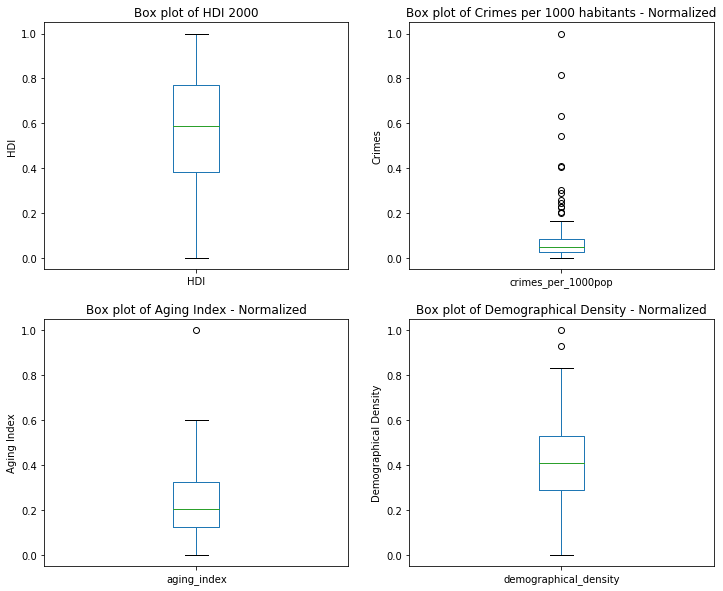

In [22]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (2 rows, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (2 rows, 2 columns, second plot)
ax2 = fig.add_subplot(2, 2, 3) # add subplot 2 (2 rows, 2 columns, third plot)
ax3 = fig.add_subplot(2, 2, 4) # add subplot 2 (2 rows, 2 columns, fourth plot)

# Subplot 1: Box plot
df2["HDI"].plot(kind='box', figsize=(12, 10), ax=ax0) # add to subplot 1
ax0.set_title('Box plot of HDI 2000')
ax0.set_ylabel('HDI')

# Subplot 2: Box plot
df2["crimes_per_1000pop"].plot(kind='box', figsize=(12, 10), ax=ax1) # add to subplot 2
ax1.set_title ('Box plot of Crimes per 1000 habitants - Normalized')
ax1.set_ylabel('Crimes')

# Subplot 3: Box plot
df2["aging_index"].plot(kind='box', figsize=(12, 10), ax=ax2) # add to subplot 3
ax2.set_title ('Box plot of Aging Index - Normalized')
ax2.set_ylabel('Aging Index')

# Subplot 4: Box plot
df2["demographical_density"].plot(kind='box', figsize=(12, 10), ax=ax3) # add to subplot 2
ax3.set_title ('Box plot of Demographical Density - Normalized')
ax3.set_ylabel('Demographical Density')

plt.show()

<div style="text-align: justify">An interesting result of the boxplot is to see the quartiles and candidates to be outlayers. The outlayers are all the points in the plot that are below the inferior limit and above the superior limit. In some cases, theses points can be discarded, but because the dataframe have so few lines for this analysis I´ll keep all the rows.<BR>
To the next step, I need to evaluate the optimum value for the number of clusters with the elbow method. The code and the graphic can be seen below.<BR></div>

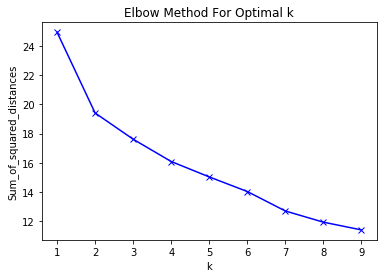

In [23]:
#tentar com 10 centroides.
df2_clustering = df2.drop('districts', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km = km.fit(df2_clustering)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We have an elbow around the k value equal 2, but to the analysis the value is too low. Then, we tried different values of k and analyze and the value that did the best clustering was 6.

In [24]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=1000, n_init=10, random_state=0).fit(df2_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 5, 0, 4, 4, 5, 2, 1, 1, 1])

Next I created a function to get top nth most common venues.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Using the function above, the num_top_venues was set to 10 and a new dataframe was created it the result with the labels.<BR>

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['districts']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['districts'] = df2['districts']

for ind in np.arange(df2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df2.iloc[ind,5:34], num_top_venues)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,districts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,AGUA RASA,Bar,Food Shop,Market,Plaza,International Restaurant,fast food restaurant,Store,Gym,Regional Restaurant,Pharmacy
1,5,ALTO DE PINHEIROS,Plaza,fast food restaurant,Regional Restaurant,Food Shop,General Entertainment,Gym,Market,Bus Station,Coffee Shop,International Restaurant
2,0,ANHANGUERA,Food Shop,General Entertainment,Store,Bus Station,Service,Park,Gym,fast food restaurant,Hotel,Bar
3,4,ARICANDUVA,Store,Food Shop,fast food restaurant,Stadium,Regional Restaurant,Pharmacy,Gym,Hotel,Bar,Bus Station
4,4,ARTUR ALVIM,Store,Regional Restaurant,fast food restaurant,Gym,Pharmacy,Bar,Food Shop,Market,Bank,Plaza


Then merged the resulting dataframe with the dataframe with geographical coordinates.

In [27]:
sp_merged = saopaulo_data

sp_merged = sp_merged.join(neighborhoods_venues_sorted.set_index('districts'), on='Borough')

sp_merged = sp_merged.dropna()
sp_merged['Cluster Labels'] = sp_merged['Cluster Labels'].astype(int)

sp_merged.head()

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MANDAQUI,-23.462176,-46.640467,1,Market,International Restaurant,Coffee Shop,Regional Restaurant,Gym,Bar,Bus Station,Club,Cultural Center,Event Space
1,MARSILAC,-23.949529,-46.724111,3,fast food restaurant,Theater,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,General Entertainment
2,MOEMA,-23.594287,-46.659987,1,Park,Store,Gym,fast food restaurant,Sports Field,Service,Regional Restaurant,Pharmacy,International Restaurant,Bar
3,PARQUE DO CARMO,-23.576289,-46.462777,0,Plaza,General Entertainment,fast food restaurant,International Restaurant,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space
4,PERDIZES,-23.540115,-46.680767,2,Gym,Food Shop,International Restaurant,Store,fast food restaurant,Theater,Bar,Regional Restaurant,Plaza,Coffee Shop


The clusters generated by the k-means algorithm can be seen in the map below.

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

rainbow = ['#cc0000', '#ffff00', '#00cc00', '#000099', '#990066', '#ff66ff', '#666666']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sp_merged['Latitude'], sp_merged['Longitude'],
                                  sp_merged['Borough'], sp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.9).add_to(map_clusters)

#map_clusters

<img src="sp_clusters.png" alt="sp cluster">

Then merged the dataframe with the columns with the HDI, crimes, demographical density and aging index.

In [34]:
df3 = pd.merge(df2.iloc[:,0:5], sp_merged, how='left', left_on='districts', right_on='Borough')
df3.drop('Borough', axis=1, inplace=True)

And the districts and their respective values are shown below.

In [35]:
df3.loc[df3['Cluster Labels'] == 0]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,ANHANGUERA,0.072597,0.059369,0.280769,0.096954,-23.433827,-46.792229,0,Food Shop,General Entertainment,Store,Bus Station,Service,Park,Gym,fast food restaurant,Hotel,Bar
22,CIDADE DUTRA,0.249696,0.146098,0.438462,0.053458,-23.745960,-46.708746,0,Store,Gym,Regional Restaurant,Pharmacy,International Restaurant,fast food restaurant,Hotel,Bar,Bus Station,Club
24,CIDADE TIRADENTES,0.527058,0.071894,0.250000,0.003013,-23.587717,-46.403887,0,Store,Food Shop,Gym,Park,fast food restaurant,International Restaurant,Bar,Bus Station,Club,Coffee Shop
29,GRAJAU,0.145471,0.069751,0.203846,0.000000,-23.798200,-46.690175,0,fast food restaurant,Theater,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,General Entertainment
31,IGUATEMI,0.242635,0.069639,0.192308,0.029171,-23.611076,-46.425679,0,fast food restaurant,International Restaurant,Coffee Shop,Regional Restaurant,Food Shop,Gym,Bar,Bus Station,Club,Cultural Center
40,JARAGUA,0.249493,0.033651,0.346154,0.019368,-23.445094,-46.736755,0,Store,Market,International Restaurant,Gym,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space
41,JARDIM ANGELA,0.294593,0.223363,0.188462,0.044372,-23.699749,-46.779752,0,fast food restaurant,International Restaurant,Store,Food Shop,Gym,Bar,Bus Station,Club,Coffee Shop,Cultural Center
45,JOSE BONIFACIO,0.328472,0.156674,0.396154,0.011230,-23.566999,-46.430827,0,International Restaurant,Sports Field,Food Shop,General Entertainment,fast food restaurant,Bar,Bus Station,Club,Coffee Shop,Cultural Center
46,LAJEADO,0.422231,0.075289,0.180769,0.035699,-23.533155,-46.401142,0,Store,Food Shop,International Restaurant,Regional Restaurant,fast food restaurant,Bar,Bus Station,Club,Coffee Shop,Cultural Center
55,PARELHEIROS,0.030491,0.061178,0.176923,0.014072,-23.818070,-46.722026,0,fast food restaurant,Theater,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,General Entertainment


In [173]:
df3.loc[df3['Cluster Labels'] == 1]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AGUA RASA,0.460079,0.357660,0.711538,0.011751,-23.566671,-46.572249,1,Bar,Food Shop,Market,Plaza,International Restaurant,fast food restaurant,Store,Gym,Regional Restaurant,Pharmacy
7,BELEM,0.279980,0.184118,0.753846,0.022144,-23.536775,-46.593056,1,Regional Restaurant,International Restaurant,Food Shop,Gym,fast food restaurant,Sports Field,Bar,Pharmacy,Park,Plaza
8,BOM RETIRO,0.316101,0.150050,0.626923,0.226818,-23.528547,-46.633860,1,International Restaurant,Regional Restaurant,Store,Food Shop,Coffee Shop,fast food restaurant,Bar,Museum,Plaza,Market
9,BRAS,0.311918,0.121771,0.642308,0.290718,-23.544013,-46.619433,1,Store,Regional Restaurant,Food Shop,fast food restaurant,Coffee Shop,Park,Bar,General Entertainment,Gym,Hotel
11,BUTANTA,0.160995,0.388778,0.873077,0.090524,-23.578210,-46.737658,1,Food Shop,fast food restaurant,Gym,International Restaurant,Market,Bar,Regional Restaurant,Pharmacy,Plaza,Park
13,CAMBUCI,0.353623,0.245380,0.776923,0.128621,-23.568158,-46.618332,1,Regional Restaurant,Gym,Store,Food Shop,Market,Service,Coffee Shop,Pharmacy,International Restaurant,Hospital
14,CAMPO BELO,0.278567,0.397128,0.888462,0.065979,-23.630901,-46.668835,1,Regional Restaurant,Bar,Store,International Restaurant,Sports Field,fast food restaurant,Hotel,Bus Station,Club,Coffee Shop
15,CAMPO GRANDE,0.286673,0.260883,0.846154,0.029247,-23.679083,-46.680788,1,International Restaurant,Store,Food Shop,Gym,fast food restaurant,Pharmacy,Coffee Shop,General Entertainment,Market,Plaza
19,CARRAO,0.414741,0.348809,0.711538,0.000912,-23.551422,-46.543217,1,Bar,Food Shop,fast food restaurant,International Restaurant,Regional Restaurant,Plaza,Coffee Shop,General Entertainment,Gym,Market
20,CASA VERDE,0.450566,0.243849,0.665385,0.082163,-23.492843,-46.660419,1,Store,Bar,fast food restaurant,Pharmacy,Bus Station,Food Shop,Gym,Market,Sports Field,Regional Restaurant


In [174]:
df3.loc[df3['Cluster Labels'] == 2]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,BELA VISTA,1.000000,0.326264,0.919231,0.206966,-23.560643,-46.645906,2,International Restaurant,Store,Bar,fast food restaurant,Gym,Regional Restaurant,Theater,Coffee Shop,Food Shop,Market
25,CONSOLACAO,0.579692,0.597751,0.957692,0.226316,-23.547553,-46.662810,2,International Restaurant,Store,Regional Restaurant,Food Shop,fast food restaurant,Gym,Coffee Shop,Bar,Market,Service
43,JARDIM PAULISTA,0.543538,0.059508,0.984615,0.202518,-23.564677,-46.668809,2,International Restaurant,Store,Regional Restaurant,Food Shop,fast food restaurant,Coffee Shop,Service,Gym,Bar,Museum
48,LIBERDADE,0.698514,0.323174,0.903846,0.084184,-23.566940,-46.631545,2,International Restaurant,Store,fast food restaurant,Gym,Market,Food Shop,Regional Restaurant,Bar,Pharmacy,Service
60,PERDIZES,0.681629,0.464429,0.984615,0.112894,-23.540115,-46.680767,2,Gym,Food Shop,International Restaurant,Store,fast food restaurant,Theater,Bar,Regional Restaurant,Plaza,Coffee Shop
66,REPUBLICA,0.927232,0.272239,0.769231,0.258330,-23.544975,-46.639659,2,Regional Restaurant,Coffee Shop,International Restaurant,Bar,Food Shop,fast food restaurant,Store,Gym,Theater,Cultural Center
69,SANTA CECILIA,0.803199,0.337481,0.880769,0.411589,-23.532843,-46.651791,2,Regional Restaurant,Food Shop,Store,International Restaurant,Bar,Gym,fast food restaurant,Theater,Market,Pharmacy
78,SAUDE,0.549338,0.437236,0.926923,0.006571,-23.614105,-46.640832,2,International Restaurant,Regional Restaurant,Food Shop,Store,Gym,Pharmacy,fast food restaurant,Market,Bar,Coffee Shop
91,VILA MARIANA,0.567265,0.494266,0.957692,0.072022,-23.583156,-46.636566,2,Food Shop,International Restaurant,Store,Service,Bar,Coffee Shop,Regional Restaurant,Gym,Hotel,fast food restaurant


In [175]:
df3.loc[df3['Cluster Labels'] == 3]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,MARSILAC,0.000000,0.143871,0.000000,0.633938,-23.949529,-46.724111,3,fast food restaurant,Theater,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space,Food Shop,General Entertainment
56,PARI,0.222084,0.163354,0.623077,0.815278,-23.527704,-46.618567,3,International Restaurant,Regional Restaurant,Store,Bar,Shopping Plaza,Food Shop,fast food restaurant,Hotel,Bus Station,Club
79,SE,0.420674,0.099449,0.603846,1.000000,-23.547740,-46.630805,3,Store,Regional Restaurant,International Restaurant,Coffee Shop,Museum,Bar,fast food restaurant,Cultural Center,Service,Food Shop


In [32]:
df3.loc[df3['Cluster Labels'] == 4]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,ARICANDUVA,0.507526,0.253257,0.496154,0.030913,-23.576873,-46.515918,4,Store,Food Shop,fast food restaurant,Stadium,Regional Restaurant,Pharmacy,Gym,Hotel,Bar,Bus Station
4,ARTUR ALVIM,0.596405,0.229626,0.507692,0.061663,-23.537624,-46.486201,4,Store,Regional Restaurant,fast food restaurant,Gym,Pharmacy,Bar,Food Shop,Market,Bank,Plaza
10,BRASILANDIA,0.471388,0.083695,0.261538,0.036875,-23.452757,-46.691623,4,Market,Gym,Bus Station,fast food restaurant,Store,Sports Field,Shopping Plaza,Bar,Club,Coffee Shop
12,CACHOEIRINHA,0.403009,0.114201,0.388462,0.008731,-23.455371,-46.661465,4,Market,fast food restaurant,Store,Stadium,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space
16,CAMPO LIMPO,0.617501,0.108161,0.403846,0.035694,-23.640093,-46.769895,4,fast food restaurant,Store,Club,Service,Regional Restaurant,Gym,International Restaurant,Hotel,Bar,Bus Station
17,CANGAIBA,0.318573,0.169868,0.476923,0.028368,-23.494461,-46.515452,4,Market,Bar,Sports Field,Service,Regional Restaurant,Park,Food Shop,Gym,Hotel,Bus Station
18,CAPAO REDONDO,0.739227,0.092157,0.311538,0.045320,-23.672645,-46.783653,4,fast food restaurant,Pharmacy,Regional Restaurant,Service,Park,Market,Store,Shopping Plaza,Gym,Bar
21,CIDADE ADEMAR,0.831598,0.118737,0.380769,0.050142,-23.675036,-46.655991,4,Market,Store,Food Shop,International Restaurant,Bar,Bus Station,Club,Coffee Shop,Cultural Center,Event Space
23,CIDADE LIDER,0.463753,0.144233,0.446154,0.027123,-23.560984,-46.483296,4,Store,Service,Gym,Hotel,fast food restaurant,International Restaurant,Bar,Bus Station,Club,Coffee Shop
27,ERMELINO MATARAZZO,0.488036,0.135410,0.384615,0.022193,-23.491705,-46.486561,4,fast food restaurant,Regional Restaurant,Food Shop,Pharmacy,Plaza,Market,Service,School,Bar,Bus Station


In [36]:
df3.loc[df3['Cluster Labels'] == 5]

,districts,demographical_density,aging_index,HDI,crimes_per_1000pop,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,ALTO DE PINHEIROS,0.208379,0.589485,0.976923,0.405625,-23.543132,-46.707131,5,Plaza,fast food restaurant,Regional Restaurant,Food Shop,General Entertainment,Gym,Market,Bus Station,Coffee Shop,International Restaurant
5,BARRA FUNDA,0.094740,0.277833,0.830769,0.544877,-23.520953,-46.678375,5,Club,Hotel,Plaza,Store,Sports Field,International Restaurant,Food Shop,Park,Market,Regional Restaurant
37,JACANA,0.453176,1.000000,0.442308,0.072378,-23.454077,-46.576679,5,Market,Coffee Shop,Plaza,International Restaurant,Bar,Bus Station,Club,Cultural Center,Event Space,Food Shop
71,SANTO AMARO,0.170423,0.419923,0.930769,0.147290,-23.641502,-46.690055,5,Market,Store,Bar,Plaza,International Restaurant,Bus Station,Club,Coffee Shop,Cultural Center,Event Space


Finally I calculated the mean for each cluster.

In [31]:
df4 = df3.groupby('Cluster Labels').mean()
df4.iloc[:,0:4]

,demographical_density,aging_index,HDI,crimes_per_1000pop
Cluster Labels,,,,
0,0.245525,0.099269,0.288718,0.039738
1,0.330136,0.296171,0.757343,0.083851
2,0.705601,0.368039,0.920513,0.175710
3,0.214252,0.135558,0.408974,0.816405
4,0.533994,0.163991,0.427644,0.033064
5,0.231680,0.571810,0.795192,0.292543


<div style="text-align: justify">The clusters formed by the kmeans algorithm present some interesting insights that will be explained more in the results and discussion section.</div>

## V) Results and Discussion <a name="results"></a>

<div style="text-align: justify">The result obtained with the k-means algorithm brought some interesting insights. <BR>
Analyzing the first cluster, whose label is equal to 0, we can see that it is composed of districts with HDI, on average, low with value around 0.289, has a low degree of criminality, a low aging index and a low demographic density. Among the most common places in these districts are "Gym", "Restaurants" and "Bar". From the map we can see that the districts are concentrated on the outskirts of the city.<BR>
For the cluster with a label of 1, the HDI has a medium-high value of 0.757. Low crime, with a low population density and an aging index slightly higher than that of the previous cluster. Among the most common locations in these districts are "Restaurants" and "Store". From the map we can see that the districts are the ones around the center, with some points on the periphery.<BR>
For the cluster with a label equal to 2, HDMI has a high value of 0.920. Low crime, with a high population density and a relatively high aging index when compared to the average of the other clusters. Among the most common places are "Restaurants" and "Store". From the map we can see that the districts are concentrated in central points of the city in tourist points of the city and some considered to be of a high standard.<BR>
For the cluster with a label equal to 3, HDMI has a medium-low value of 0.409. High crime rate, low population density and a low aging index. Among the most common places are "Restaurants" and "Bar". From the map we can see that the districts correspond to the center of the city and one in the extreme south on the periphery.<BR>
For the cluster with a label equal to 4, HDMI has a medium-low value of 0.428. Low crime rate, average population density and low aging index. Among the most common places in the neighborhood are the "Store", "Market" and "Restaurant". From the map we can see that the districts are concentrated on the outskirts of the city in the south, in the north and east of the city.<BR>
For the cluster with a label equal to 5, HDMI has a high value of 0.795, criminality among the top 2, low demographic density and with a higher aging index among all clusters. Among the most common places in the neighborhood are the "Market", "Plaza" and "Restaurant". From the map we can see that the districts are spread across the city.<BR>
It is important to note that it is visible that due to the k-means algorithm trying to fit all the data in a cluster, we have data in some groups that differ from the group average. For example, as we can see in the cluster label equal to 5. Where the district of Jacana is clearly distorting the average of the cluster.<BR>
</div>
<div style="text-align: justify">Another interesting point that is visible is that in most clusters, the locations do not have a very well defined pattern, becoming partly random as we could anticipate with the correlation matrix. To improve the analysis, in a next step, some information such as transportation (metro and train station) should be placed, because the accessibility of the low influence in a certain way on the profile of the neighborhood. In addition to using more filters in types of locations used in the analysis such as school, hospital, among others. And collect more API-specific information focused on the business the stakeholders want to open.</div>

 ## VI) Conclusion  <a name="conclusion"></a>

<div style="text-align: justify">The purpose of the study was to identify patterns between the districts of the city of São Paulo to identify possible clusters with the potential to open a business. For this, in addition to the location of locations given by the Foursquare API, demographic and social indicators were used. Thus, the study resulted in some interesting results, forming clusters with a certain consistency in the average and distribution of its indicators. It is important to note here that due to the unsupervised K-means method trying to fit all data in one of the clusters, some districts were allocated to groups whose value was very different from the rest. Even so, the information is useful if you want to obtain possible candidates to receive a business affiliate.<BR>
As a next step, it would be interesting to add more metrics and filter the information from the Foursquare API for the business area that the stakeholders really want to establish in order to assess competition and possible risks in implementing the unit.<BR></div>